In [ ]:
from sklearn.feature_selection import mutual_info_classif
from tabpfn import TabPFNClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

df_train = pd.read_parquet("data_trabalho_train.parquet")
df_test  = pd.read_parquet("data_trabalho_test.parquet")

In [85]:
df_train.head(10)

,subject_id,idx,gender,anchor_age,event,death,date
0,10694616,2186-11-03 03:57:00,F,32,LAB_HEMOGLOBIN,False,NaT
1,10884861,2173-09-10 11:00:00,M,69,MED_Potassium_Chloride,False,NaT
2,13777050,2141-08-17 02:05:00,F,79,LAB_AMYLASE,True,2141-08-17
3,18082975,2118-01-22 21:07:00,M,46,DIAGN_Z59,False,2118-01-22
4,11711049,2156-10-29 22:53:00,F,33,LAB_LYMPHOCYTES,False,NaT
5,10828990,2153-10-31 04:43:00,M,58,LAB_MCHC,True,NaT
6,13802637,2188-02-01 22:39:00,F,43,LAB_AMPHETAMINE_SCREEN__URINE,True,NaT
7,11038422,2150-03-09 00:35:00,F,72,LAB_WBC,False,NaT
8,11584490,2133-10-09 15:34:00,F,28,LAB_RED_TOP_HOLD,False,NaT
9,11588742,2166-12-19 00:00:00,M,70,LAB_MCV,True,NaT


In [86]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4125219 entries, 0 to 4125218
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   idx         object        
 2   gender      object        
 3   anchor_age  int64         
 4   event       category      
 5   death       bool          
 6   date        datetime64[ns]
dtypes: bool(1), category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 169.5+ MB


In [87]:
df_train.describe()

,subject_id,anchor_age,date
count,4.125219e+06,4.125219e+06,410347
mean,1.229095e+07,5.833001e+01,2157-10-26 13:55:25.631237120
min,1.000008e+07,1.800000e+01,2109-03-11 00:00:00
25%,1.102161e+07,4.700000e+01,2138-01-02 00:00:00
50%,1.212677e+07,6.100000e+01,2157-07-31 00:00:00
75%,1.318465e+07,7.200000e+01,2177-11-17 00:00:00
max,1.999946e+07,9.100000e+01,2211-11-08 00:00:00
std,1.683101e+06,1.824624e+01,NaN


Total death per gender:

<Axes: xlabel='gender', ylabel='death'>

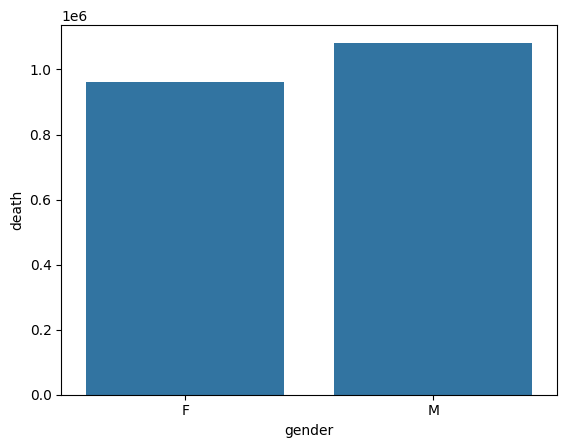

In [88]:
death_per_gender = df_train.groupby('gender')['death'].sum()
sns.barplot(death_per_gender)

Death per age and per gender:

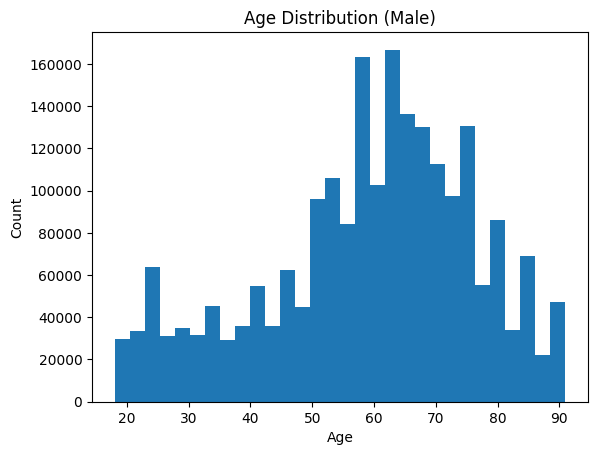

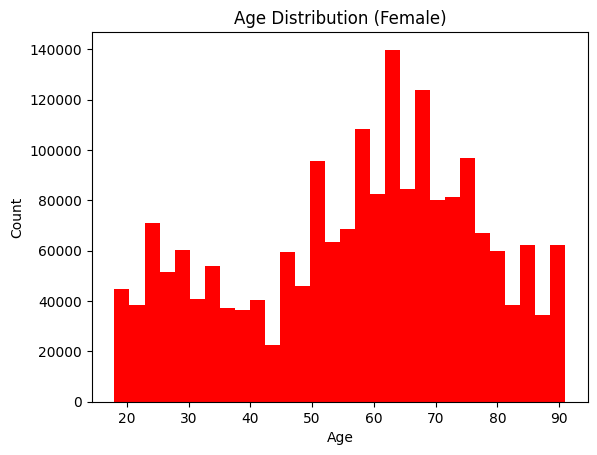

In [89]:
hist_death_masc   = df_train[df_train['gender'] == 'M'][['death', 'anchor_age']]
hist_death_female = df_train[df_train['gender'] == 'F'][['death', 'anchor_age']]

plt.hist(hist_death_masc['anchor_age'], bins=30)
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution (Male)")
plt.show()

plt.hist(hist_death_female['anchor_age'], bins=30, color='red')
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution (Female)")
plt.show()

Count by type of events:

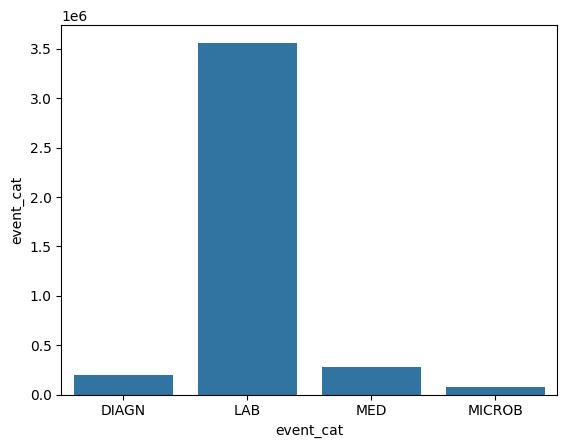

In [90]:
temp = df_train.copy()
temp[['event_cat', 'event_detail']] = temp['event'].str.split("_", n=1, expand=True)
count = temp.groupby('event_cat')['event_cat'].count()

sns.barplot(data=count)
plt.show()

Top 20 most appearing events:

<Axes: xlabel='0,1'>

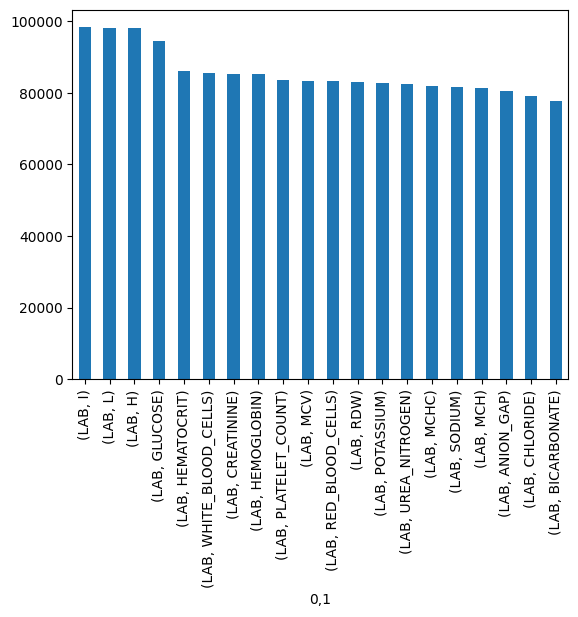

In [91]:
temp = df_train.copy()
counts = temp['event'].str.split("_", n=1, expand=True).value_counts().head(20)
counts.plot(kind='bar')

Deaths per "shift":

/var/folders/xb/dnjxhntx75jbglwhpt5wvl4h0000gn/T/ipykernel_37136/3397119278.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  shift = test.groupby('shift')['death'].count()


<Figure size 640x480 with 0 Axes>

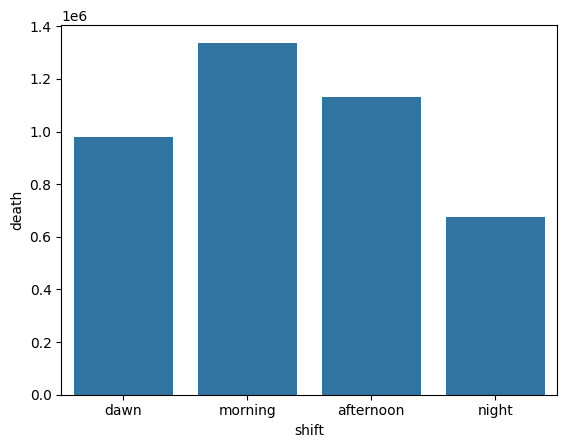

<Figure size 640x480 with 0 Axes>

In [92]:
hours = pd.to_datetime(
    df_train["idx"].str.split().str[1],
    format="%H:%M:%S"
).dt.hour

bins = [0, 6, 12, 18, 24]          
labels = ["dawn", "morning", "afternoon", "night"]

test = df_train.copy()
test['shift'] = pd.cut(hours, bins=bins, labels=labels, right=False)

shift = test.groupby('shift')['death'].count()

sns.barplot(data=shift)
plt.figure()

Check for Nans/Nulls:

In [93]:
df_train.isna().sum()

subject_id          0
idx                 0
gender              0
anchor_age          0
event               0
death               0
date          3714872
dtype: int64

### Feature engineering:

In [ ]:
def process(df):
    df['death'] = df['death'].astype(int)

    # Should i separate the prefix of the event from it?
    df[['event_cat', 'event_detail']] = df['event'].str.split("_", n=1, expand=True)

    # Get dummies to make a bunch of columns for each feature
    df = pd.get_dummies(df, columns=["event_cat"], prefix="type")
    df = pd.get_dummies(df, columns=["event_detail"], prefix="detail")

    df['date']  = pd.to_datetime(df['idx'].str.split().str[0])
    df['year']  = df['date'].dt.year

    # Should i get dummies?
    df['month'] = df['date'].dt.month

    df['gender'] = df['gender'].map({'F': 0, 'M': 1})

    bins = [0, 6, 12, 18, 24]          
    labels = ["dawn", "morning", "afternoon", "night"]

    # Should i get dummies?
    hours = pd.to_datetime(df["idx"].str.split().str[1], format="%H:%M:%S").dt.hour
    df['shift'] = pd.cut(hours, bins=bins, labels=labels, right=False)
    df['shift'] = df['shift'].cat.codes

    # Why do i want to get dummies so much?
    df['dayoftheweek'] = df['date'].dt.dayofweek
    df['isweekend'] = df['dayoftheweek'].isin([5,6]).astype(int) 

    df = df.drop(columns=['event', 'idx', 'date'])

    # do i need aggregation?
    df = df.groupby("subject_id").agg(
        gender=("gender", "first"),
        death=("death", "max"),

        # all detail_* and type_*
        **{col: (col, "sum") for col in df.columns if col.startswith("type_")},
        **{col: (col, "sum") for col in df.columns if col.startswith("detail_")},

        # temporal features
        year_min=("year", "min"),
        year_max=("year", "max"),
        spent_years=("year", lambda x: x.max() - x.min()),

        month_nunique=("month", "nunique"),
        most_shift=("shift", lambda x: x.mode().iloc[0] if not x.mode().empty else -1),

        isweekend_sum=("isweekend", "sum")
    )

    return df


In [ ]:
df_train = process(df_train)
train_cols = df_train.columns
df_train.head()

,gender,death,type_DIAGN,type_LAB,type_MED,type_MICROB,detail_A02,detail_A04,detail_A08,detail_A09,...,detail_vortioxetine,detail_zinc_chloride,detail_zoledronic_acid,detail_zolmitriptan,year_min,year_max,spent_years,month_nunique,most_shift,isweekend_sum
subject_id,,,,,,,,,,,,,,,,,,,,,
10000084,1,1,10,220,9,3,0,0,0,0,...,0,0,0,0,2160,2160,0,2,1,107
10000285,1,1,0,84,0,1,0,0,0,0,...,0,0,0,0,2159,2161,2,1,2,54
10000473,1,1,0,49,0,1,0,0,0,0,...,0,0,0,0,2138,2138,0,1,3,50
10000492,1,1,0,37,0,0,0,0,0,0,...,0,0,0,0,2129,2129,0,1,2,0
10000935,0,1,0,15,0,0,0,0,0,0,...,0,0,0,0,2182,2187,5,5,1,3


In [98]:
X_train = df_train.drop(columns="death")
y_train = df_train['death']

In [124]:
df_test = pd.read_parquet("data_trabalho_test.parquet")
df_test = process(df_test)
df_test = df_test.reindex(columns=train_cols, fill_value=0)
X_test = df_test.drop(columns="death")
y_test = df_test['death']

### Feature selection:

Uses a Variance Threshold to reduce the number of columns (removes columns that remain too staticj)

XGBoost for feature importance:

In [99]:
model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [131]:
y_pred = model.predict(X_train)

accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9137


In [115]:
thresholds = np.sort(model.feature_importances_)
selection = None
for thresh in thresholds:
    selection = SelectFromModel(model, threshold=thresh, prefit=True)

In [125]:
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)

/Users/viniciusguerra/Documents/pesquisa/notebooks/task_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/viniciusguerra/Documents/pesquisa/notebooks/task_1/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [132]:
selection_model = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1)
selection_model.fit(select_X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [133]:
predictions = selection_model.predict(select_X_test)
accuracy = accuracy_score(y_test, predictions)
accuracy

0.5113936490387568

In [ ]:
class VarianceSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.selector = VarianceThreshold(threshold=threshold)
        self.keep_cols = None

    def fit(self, X, y=None):
        self.selector.fit(X)

        mask = self.selector.get_support()
        self.keep_cols = X.columns[mask]

        return self

    def transform(self, X):
        return X[self.keep_cols]


Uses correlation Matrice to reduce the number of columns, removig columns that seem much alike linearly

In [ ]:
class CorrelationSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.drop = None

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()

        upper = corr_matrix.where(
            np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        )

        self.drop = [
            column for column in upper.columns
            if any(upper[column] > 0.95)
        ]

        return self

    def transform(self, X):
        return X.drop(columns=self.drop)


Calculates MI-Scores to remove columns that have low entropy (correlation but for non linear relationships)

In [ ]:
class MiSelector(BaseEstimator, TransformerMixin):
    def __init__(self, top_k=500):
        self.top_k = top_k
        self.keep_cols = None

    def fit(self, X, y=None):
        mi_scores = mutual_info_classif(X, y)
        mi_scores = pd.Series(mi_scores, index=X.columns)

        # Select top_k features
        self.keep_cols = mi_scores.sort_values(ascending=False).index[:self.top_k]

        return self

    def transform(self, X):
        return X[self.keep_cols]


In [ ]:
pipe = Pipeline([
    ('variance', VarianceSelector(0.0009)),
    ('correlation', CorrelationSelector()),
])

,steps,"[('variance', ...), ('correlation', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,threshold,0.0009
,top_k,500


In [ ]:
df_test = pd.read_parquet("data_trabalho_test.parquet")
X_test = process(df_test)
y_true = X_test.pop('death')

In [ ]:
X_test = X_test.reindex(columns=train_cols, fill_value=0)
X_test_selected = pipe.transform(X_test)
X_test_selected.head()

/Users/viniciusguerra/Documents/pesquisa/notebooks/task_1/.venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


,type_LAB,detail_ABSOLUTE_BASOPHIL_COUNT,detail_IMMATURE_GRANULOCYTES,type_DIAGN,detail_ESTIMATED_GFR__MDRD_EQUATION_,spent_years,detail_GREEN_TOP_HOLD__PLASMA_,detail_BLOOD,type_MED,detail_LENGTH_OF_URINE_COLLECTION,...,detail_S12,detail_TOXOPLASMA_IGG_ANTIBODY_nan,detail_M45,detail_OLANZapine__Disintegrating_Tablet_,detail_ASSIST_CONTROL,detail_CeFAZolin,detail_PROTEIN_CREATININE_RATIO,detail_O48,detail_Phenytoin_Sodium_Extended,detail_Y71
subject_id,,,,,,,,,,,,,,,,,,,,,
10000084,54,0,1,2,1,0,0,0,4,1,...,0,0,0,0,0,0,0,0,0,0
10000285,20,0,2,0,2,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000473,10,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000492,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10000935,2,0,0,0,0,4,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0


(34741, 500)

In [ ]:

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

size = len(X_selected)
idx = np.random.choice(len(X_selected), size, replace=False)
X_small = X_selected.iloc[idx]
y_small = y.iloc[idx]

clf = TabPFNClassifier(device=device)
clf.fit(X_small, y_small)

,n_estimators,8
,categorical_features_indices,None
,softmax_temperature,0.9
,balance_probabilities,False
,average_before_softmax,False
,model_path,'auto'
,device,device(type='mps')
,ignore_pretraining_limits,False
,inference_precision,'auto'
,fit_mode,'fit_preprocessors'
,memory_saving_mode,'auto'


In [ ]:
'''
accuracy_score(y_pred, y_true)
'''

'\naccuracy_score(y_pred, y_true)\n'

In [ ]:
'''
f1_score(y_pred=y_pred, y_true=y_true)
'''

'\nf1_score(y_pred=y_pred, y_true=y_true)\n'